In [34]:
import os
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import itertools
import collections
from scipy import stats
import plot_functions as pf

In [35]:
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [36]:
!pwd
!ls

/Users/katerinaschulz/Workspace/Galvanize/Capstone1/EDA-Waymo-Open-Dataset
README.md              frames8k.csv           plot_functions.py
Waymo-Analysis.md      frames_to_Pandas.py    unpack.sh
Waymo-Object-EDA.ipynb libraries.py           waymo_top.png
__pycache__            objects.csv
frames.csv             objects500k.csv


In [37]:
objects_df = pd.read_csv('objects500k.csv')

In [67]:
objects_df['distance'] = np.sqrt(objects_df['location_x']**2 + objects_df['location_y']**2)

In [68]:
objects_df.head()

,Unnamed: 0,category,dimension_height,dimension_length,dimension_width,heading,location_x,location_y,location_z,distance
0,0,pedestrian,1.889434,1.036285,0.869548,28.046370,-21.392696,34.256657,-0.167213,40.387696
1,1,pedestrian,1.650000,0.905959,0.784573,-176.548462,10.391662,20.009092,0.140395,22.546627
2,2,pedestrian,2.000000,0.655752,0.789083,154.997238,67.121521,0.957747,1.680581,67.128354
3,3,pedestrian,2.100000,0.734008,0.863620,89.197525,28.183521,-33.817711,3.271440,44.022136
4,4,pedestrian,1.642014,0.941461,0.776469,-169.396439,-65.372452,17.677683,-0.608567,67.720439


In [71]:
pedestrians = objects_df[objects_df['category'] == 'pedestrian']
cyclists = objects_df[objects_df['category'] == 'cyclist']
vehicles = objects_df[objects_df['category'] == 'vehicle']
signs = objects_df[objects_df['category'] == 'sign']

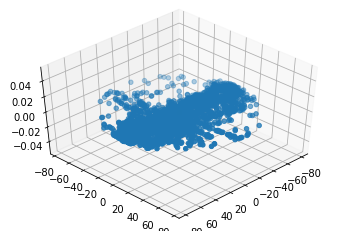

In [97]:
ax = plt.axes(projection='3d')
ax.view_init(45, 45)

zdata = np.zeros(len(cyclists['location_z']))
xdata = cyclists['location_x']
ydata = cyclists['location_y']
ax.scatter3D(xdata, ydata, zdata)

z = 0
y = 0
x = 0
ax.scatter3D(x, y, z, 'Blue', marker='o');

In [41]:
def plot_obj_pc(object_type, color='b', alpha=0.1):
	ax = plt.axes()

	xdata = object_type['location_x']
	ydata = object_type['location_y']
	ax.scatter(xdata, ydata, c=color, alpha=alpha)

	waymo_y = 0
	waymo_x = 0
	ax.scatter(waymo_x, waymo_y, c='k');

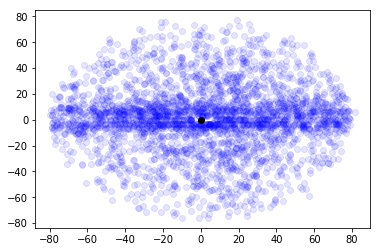

In [99]:
plot_obj_pc(vehicles.sample(3000), color='b', alpha=0.1)

In [65]:
def plot_subgroup_hist(df, sub_a, sub_b):
    '''
    Displays information of 2 sub groups of a data set 
    '''
    
    fig, axs = plt.subplots(1,3, figsize=(15, 3))
    for col_name, ax in zip(df.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 30)
        height, binz = np.histogram(sub_a[col_name], bins=bins, density=True)
        bp1 = ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.5, label=sub_a, color='g')
        height, binz = np.histogram(sub_b[col_name], bins=bins, density=True)
        bp2 = ax.bar(bins[:-1]+.5*(bins[1]-bins[0]), height,
                     .5*(bins[1]-bins[0]), color='b', alpha=.5)
        ax.set_title(col_name)
        ax.legend((bp1[0], bp2[0]), ("Pedestrian", "Vehicle"), loc='best')

    plt.tight_layout()

    return fig, ax

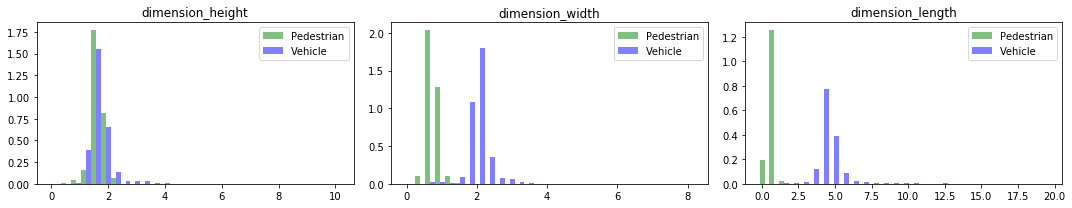

In [66]:
dimension_cols = ['dimension_height', 'dimension_width', 'dimension_length']
plot_subgroup_hist(objects_df[dimension_cols], pedestrians[dimension_cols], vehicles[dimension_cols]);

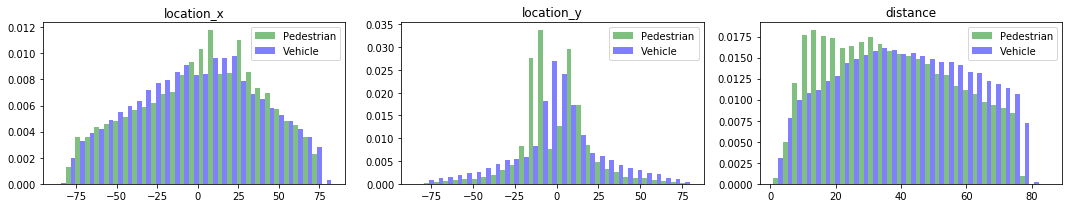

In [72]:
distance_cols = ['location_x', 'location_y', 'distance']
plot_subgroup_hist(objects_df[distance_cols], pedestrians[distance_cols], vehicles[distance_cols]);

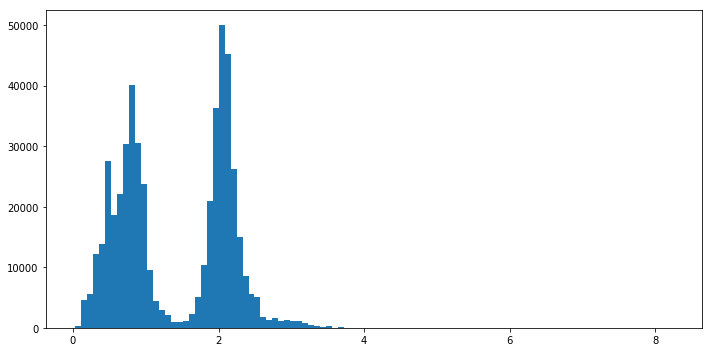

In [80]:
objects_df['dimension_width'].hist(bins=100,figsize=(10, 5), grid=False)
plt.tight_layout()

In [ ]:
objects_df['dimension_width'].hist(bins=100,figsize=(10, 5), grid=False)
plt.tight_layout()

In [92]:
def plot_subgroup_hist(df, subs):
    num_subs = len(subs)
    bp = []
    fig, axs = plt.subplots(1,3, figsize=(15, 3))
    for col_name, ax in zip(df.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 30)
        
        for sub in subs:
            height, binz = np.histogram(sub[col_name], bins=bins, density=True)
            bp.append(ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.75, label=sub))
        
        #height, binz = np.histogram(sub_b[col_name], bins=bins, density=True)
        #bp2 = ax.bar(bins[:-1]+.5*(bins[1]-bins[0]), height,
        #            .5*(bins[1]-bins[0]), color='b', alpha=.5)
        ax.set_title(col_name)
        bp_leg = tuple(i[0] for i in bp)
        
        ax.legend(bp_leg, sub_leg, loc='best')

    plt.tight_layout()

    return fig, ax

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

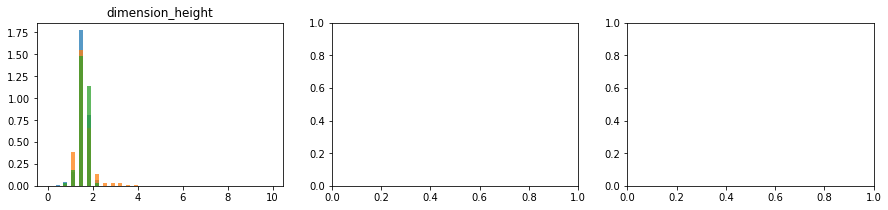

In [93]:
plot_subgroup_hist(objects_df[dimension_cols], [pedestrians[dimension_cols], vehicles[dimension_cols], cyclists[dimension_cols]]);